## Low-Rank Autoregressive Tensor Completion Predictor (LATC-predictor)

This notebook shows how to implement a LATC predictor on three real-world data sets (e.g., PeMS traffic speed data, Guangzhou traffic speed data, and electricity data set). To overcome the problem of missing values within multivariate time series data, the proposed LATC model takes into account both low-rank structure and time series regression. Note that this `LATC-predictor` is based on `LATC-imputer`. For an in-depth discussion of LATC-predictor, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2020). <b>Low-Rank Autorgressive Tensor Completion for Multivariate Time Series Forecasting</b>. arXiv.2006.10436. <a href="https://arxiv.org/pdf/2006.10436.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

If you want to use this notebook, please download or clone our GitHub project ([**tensor-learning**](https://github.com/xinychen/tensor-learning)) on your computer.

In [1]:
import numpy as np
from numpy.linalg import inv as inv
import matplotlib.pyplot as plt

%matplotlib inline

### Define LATC-imputer kernel

We start by introducing some necessary functions that relies on `Numpy`.

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>ten2mat</code>:</b> <font color="black">Unfold tensor as matrix by specifying mode.</font></li>
<li><b><code>mat2ten</code>:</b> <font color="black">Fold matrix as tensor by specifying dimension (i.e, tensor size) and mode.</font></li>
<li><b><code>svt_tnn</code>:</b> <font color="black">Implement the process of Singular Value Thresholding (SVT) for Truncated Nuclear Norm (TNN) minimization.</font></li>
</ul>
</div>

In [2]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

In [3]:
def svt_tnn(mat, tau, theta):
    [m, n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        idx = np.sum(s > tau)
        mid = np.zeros(idx)
        mid[: theta] = 1
        mid[theta : idx] = (s[theta : idx] - tau) / s[theta : idx]
        return (u[:, : idx] @ np.diag(mid)) @ (u[:, : idx].T @ mat)
    elif m > 2 * n:
        return svt_tnn(mat.T, tau, theta).T
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    idx = np.sum(s > tau)
    vec = s[: idx].copy()
    vec[theta : idx] = s[theta : idx] - tau
    return u[:, : idx] @ np.diag(vec) @ v[: idx, :]

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>compute_mape</code>:</b> <font color="black">Compute the value of Mean Absolute Percentage Error (MAPE).</font></li>
<li><b><code>compute_rmse</code>:</b> <font color="black">Compute the value of Root Mean Square Error (RMSE).</font></li>
</ul>
</div>

> Note that $$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}}, \quad\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}},$$ where $n$ is the total number of estimated values, and $y_i$ and $\hat{y}_i$ are the actual value and its estimation, respectively.

In [4]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

The main idea behind LATC-imputer is to approximate partially observed data with both low-rank structure and time series dynamics. The following `imputer` kernel includes some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>dense_tensor</code>:</b> <font color="black">This is an input which has the ground truth for validation. If this input is not available, you could use <code>dense_tensor = sparse_tensor.copy()</code> instead.</font></li>
<li><b><code>sparse_tensor</code>:</b> <font color="black">This is a partially observed tensor which has many missing entries.</font></li>
<li><b><code>time_lags</code>:</b> <font color="black">Time lags for defining autoregressive time series, e.g., <code>time_lags = np.array([1, 2, 3])</code>. </font></li>
<li><b><code>alpha</code>:</b> <font color="black">Weights for tensor nuclear norm, e.g., <code>alpha = np.ones(3) / 3</code>. </font></li>
<li><b><code>rho</code>:</b> <font color="black">Learning rate of ADMM algorithm, e.g., <code>rho = 0.0001</code>. </font></li>
<li><b><code>lambda0</code>:</b> <font color="black">Weight for time series regressor, e.g., <code>lambda0 = 5 * rho</code>. If <code>lambda0 = 0</code>, then this imputer is actually a standard low-rank tensor completion with nuclear norm or truncated nuclear norm (i.e., HaLRTC or HaLRTC-TNN).</font></li>
<li><b><code>theta</code>:</b> <font color="black">Truncation (nonnegative number) for truncated nuclear norm. If <code>theta = 0</code>, then this imputer is actually a low-rank autoregressive tensor completion with nuclear norm (i.e., LATC-NN).</font></li>
<li><b><code>epsilon</code>:</b> <font color="black">Stop criteria, e.g., <code>epsilon = 0.0001</code>. </font></li>
<li><b><code>maxiter</code>:</b> <font color="black">Maximum iteration to stop algorithm, e.g., <code>maxiter = 100</code>. </font></li>
</ul>
</div>


In [5]:
def imputer(dense_tensor, sparse_tensor, time_lags, alpha, rho0, lambda0, theta, epsilon, maxiter):
    """Low-Rank Autoregressive Tensor Completion, LATC-imputer."""
    dim = np.array(sparse_tensor.shape)
    dim_time = np.int(np.prod(dim) / dim[0])
    d = len(time_lags)
    max_lag = np.max(time_lags)
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    X = np.zeros(np.insert(dim, 0, len(dim)))
    T = np.zeros(np.insert(dim, 0, len(dim)))
    Z = sparse_mat.copy()
    Z[pos_missing] = np.mean(sparse_mat[sparse_mat != 0])
    A = 0.001 * np.random.rand(dim[0], d)
    it = 0
    ind = np.zeros((d, dim_time - max_lag), dtype = np.int_)
    for i in range(d):
        ind[i, :] = np.arange(max_lag - time_lags[i], dim_time - time_lags[i])
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho = rho0
    while True:
        rho = min(rho*1.05, 1e5)
        for k in range(len(dim)):
            X[k] = mat2ten(svt_tnn(ten2mat(mat2ten(Z, dim, 0) - T[k] / rho, k), alpha[k] / rho, theta), dim, k)
        tensor_hat = np.einsum('k, kmnt -> mnt', alpha, X)
        mat_hat = ten2mat(tensor_hat, 0)
        mat0 = np.zeros((dim[0], dim_time - max_lag))
        if lambda0 > 0:
            for m in range(dim[0]):
                Qm = mat_hat[m, ind].T
                A[m, :] = np.linalg.pinv(Qm) @ Z[m, max_lag :]
                mat0[m, :] = Qm @ A[m, :]
            mat1 = ten2mat(np.mean(rho * X + T, axis = 0), 0)
            Z[pos_missing] = np.append((mat1[:, : max_lag] / rho), (mat1[:, max_lag :] + lambda0 * mat0) 
                                       / (rho + lambda0), axis = 1)[pos_missing]
        else:
            Z[pos_missing] = (ten2mat(np.mean(X + T / rho, axis = 0), 0))[pos_missing]
        T = T + rho * (X - np.broadcast_to(mat2ten(Z, dim, 0), np.insert(dim, 0, len(dim))))
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 100 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
            print('MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

    print('Total iteration: {}'.format(it))
    print('Tolerance: {:.6}'.format(tol))
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
    print()
    
    return tensor_hat

### Define LATC-predictor kernel

We devise a rolling prediction scheme for decorating `LATC-predictor`, there are some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>pred_time_steps</code>:</b> <font color="black">Total number of time points we should predict.</font></li>
<li><b><code>time_horizon</code>:</b> <font color="black">Time horizon we should forecast for each rolling window.</font></li>
<li><b><code>back_time_steps</code>:</b> <font color="black">Total number of time points for training.</font></li>
</ul>
</div>

In [6]:
def predictor(dense_mat, sparse_mat, pred_time_steps, time_horizon, back_time_steps, time_intervals,
              time_lags, alpha, rho, lambda0, theta, epsilon, maxiter):
    """LATC-predictor kernel."""
    T = dense_mat.shape[1]
    start_time = T - pred_time_steps
    dim = np.array([dense_mat.shape[0], time_intervals, int(back_time_steps / time_intervals)])
    d = len(time_lags)
    
    mat_hat = np.zeros((dim[0], pred_time_steps))
    for t in range(int(pred_time_steps / time_horizon)):
        print('The current prediction step: {}'.format(t + 1))
        start = start_time - back_time_steps + (t + 1) * time_horizon
        end = start_time  + t * time_horizon
        temp1 = np.append(dense_mat[:, start : end], np.zeros((dim[0], time_horizon)), axis = 1)
        temp2 = np.append(sparse_mat[:, start : end], np.zeros((dim[0], time_horizon)), axis = 1)
        tensor = imputer(mat2ten(temp1, dim, 0), mat2ten(temp2, dim, 0), 
                         time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
        mat_hat[:, t * time_horizon : (t + 1) * time_horizon] = (ten2mat(tensor, 0))[:, -time_horizon :]
#         fig = plt.figure(figsize = (14, 3.1))
#         plt.plot(np.mean(mat_hat, axis = 0), color = "r")
#         plt.plot(np.mean(dense_mat[:, start_time :], axis = 0), color = "b")
#         plt.show()
#         print()
        
    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat != 0)
    mape = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape))
    print('Prediction RMSE: {:.6}'.format(rmse))
    
    return mat_hat, mape, rmse

In [7]:
def validation(dense_mat, sparse_mat, pred_time_steps, time_horizon, back_time_steps, time_intervals,
               time_lags, alpha, rhos, lambdas, thetas, epsilon, maxiter):
    mapes = np.zeros((len(rhos), len(lambdas), len(thetas)))
    rmses = np.zeros((len(rhos), len(lambdas), len(thetas)))
    i = 0
    for rho in rhos:
        j = 0
        for lambda0 in lambdas:
            k = 0
            for theta in thetas:
                mat_hat, mape, rmse = predictor(dense_mat, sparse_mat, pred_time_steps, 
                                                time_horizon, back_time_steps, time_intervals,
                                                time_lags, alpha, rho, lambda0 * rho, theta, epsilon, maxiter)
                mapes[i, j, k] = mape
                rmses[i, j, k] = rmse
                print()
                print('All MAPEs:')
                print(mapes)
                print('All RMSEs:')
                print(rmses)
                print()
                k += 1
            j += 1
        i += 1
    pos = np.where(rmses == np.min(rmses))
    print('MAPE:')
    print(mapes)
    print('RMSE:')
    print(rmses)
    print('Best rho:')
    print(rhos[pos[0][0]])
    print('Best lambda:')
    print(lambdas[pos[1][0]])
    print('Best theta:')
    print(thetas[pos[2][0]])
    return mapes, rmses

### PeMS data

We generate **random missing (RM)** values on PeMS traffic speed data set.

In [8]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

We use `predictor` to predict time series (time horizon: 9) with missing values and measure performance metrics on the ground truth.

In [9]:
import time
start = time.time()
time_horizon = 9
pred_time_steps = 160 * time_horizon
time_intervals = 288
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 5e-4
lambda0 = 10 * rho
epsilon = 1e-4
maxiter = 100
theta = 10
mat_hat, mape, rmse = predictor(dense_mat, sparse_mat, 
                                pred_time_steps, time_horizon, back_time_steps, time_intervals,
                                time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
Total iteration: 63
Tolerance: 8.81843e-05
Imputation MAPE: 0.0358693
Imputation RMSE: 2.78317

The current prediction step: 2
Total iteration: 65
Tolerance: 8.1121e-05
Imputation MAPE: 0.0358718
Imputation RMSE: 2.7848

The current prediction step: 3
Total iteration: 66
Tolerance: 7.92895e-05
Imputation MAPE: 0.0358684
Imputation RMSE: 2.78457

The current prediction step: 4
Total iteration: 67
Tolerance: 9.59264e-05
Imputation MAPE: 0.035866
Imputation RMSE: 2.78462

The current prediction step: 5
Total iteration: 68
Tolerance: 7.5548e-05
Imputation MAPE: 0.0358593
Imputation RMSE: 2.78463

The current prediction step: 6
Total iteration: 68
Tolerance: 9.96724e-05
Imputation MAPE: 0.0358528
Imputation RMSE: 2.78428

The current prediction step: 7
Total iteration: 69
Tolerance: 7.62456e-05
Imputation MAPE: 0.0358486
Imputation RMSE: 2.78381

The current prediction step: 8
Total iteration: 69
Tolerance: 7.54318e-05
Imputation MAPE: 0.0358435
Imputation RMS

Total iteration: 55
Tolerance: 8.54931e-05
Imputation MAPE: 0.035634
Imputation RMSE: 2.77614

The current prediction step: 67
Total iteration: 56
Tolerance: 7.51906e-05
Imputation MAPE: 0.0356344
Imputation RMSE: 2.7762

The current prediction step: 68
Total iteration: 57
Tolerance: 7.02748e-05
Imputation MAPE: 0.0356321
Imputation RMSE: 2.77635

The current prediction step: 69
Total iteration: 57
Tolerance: 9.06069e-05
Imputation MAPE: 0.0356295
Imputation RMSE: 2.77627

The current prediction step: 70
Total iteration: 58
Tolerance: 7.80055e-05
Imputation MAPE: 0.0356258
Imputation RMSE: 2.77594

The current prediction step: 71
Total iteration: 59
Tolerance: 7.52226e-05
Imputation MAPE: 0.0356277
Imputation RMSE: 2.77607

The current prediction step: 72
Total iteration: 59
Tolerance: 9.72873e-05
Imputation MAPE: 0.0356082
Imputation RMSE: 2.77455

The current prediction step: 73
Total iteration: 60
Tolerance: 8.88921e-05
Imputation MAPE: 0.0355865
Imputation RMSE: 2.77316

The curren

Total iteration: 61
Tolerance: 7.21335e-05
Imputation MAPE: 0.0358182
Imputation RMSE: 2.78185

The current prediction step: 131
Total iteration: 61
Tolerance: 7.70102e-05
Imputation MAPE: 0.0358215
Imputation RMSE: 2.78163

The current prediction step: 132
Total iteration: 61
Tolerance: 8.17337e-05
Imputation MAPE: 0.0358215
Imputation RMSE: 2.78165

The current prediction step: 133
Total iteration: 61
Tolerance: 8.34668e-05
Imputation MAPE: 0.0358225
Imputation RMSE: 2.78192

The current prediction step: 134
Total iteration: 61
Tolerance: 8.28667e-05
Imputation MAPE: 0.0358262
Imputation RMSE: 2.78261

The current prediction step: 135
Total iteration: 62
Tolerance: 6.82403e-05
Imputation MAPE: 0.0358297
Imputation RMSE: 2.78271

The current prediction step: 136
Total iteration: 62
Tolerance: 8.5591e-05
Imputation MAPE: 0.0358219
Imputation RMSE: 2.78237

The current prediction step: 137
Total iteration: 63
Tolerance: 7.71995e-05
Imputation MAPE: 0.0358279
Imputation RMSE: 2.78306

Th

For this notebook example, we visualize traffic speeds and their forecasts of the given road segment. If you want to see the predicted traffic speed curves, please run the following code cell.

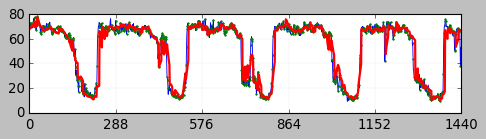

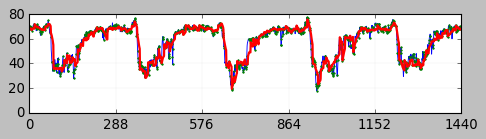

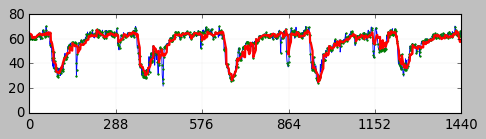

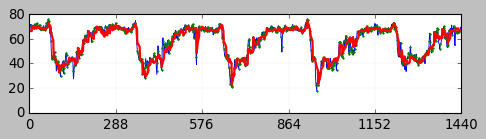

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [1, 2, 3, 4]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.05, 0.12, 0.90, 0.82])
    vec = sparse_mat[i, -pred_time_steps:]
    pos = np.where(vec > 0)
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(pos[0], vec[pos], '.', color='g', markersize = 3)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 288 * 5 + 1, 288))
    plt.yticks(np.arange(0, 80 + 1, 20))
    ax.set_xlim([0, pred_time_steps]) 
    ax.set_ylim([0, 80])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()
#     fig.savefig("../images/P{}_forecasting_time_series_40RM.pdf".format(i + 1))

We generate **nonrandom missing (NM)** values on PeMS traffic speed data set.

In [11]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_matrix = np.load('../datasets/PeMS-data-set/random_matrix.npy')

missing_rate = 0.4

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 288, 44))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(44):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)

sparse_mat = np.multiply(dense_mat, binary_mat)

We use `predictor` to predict time series (time horizon: 9) with missing values and measure performance metrics on the ground truth.

In [12]:
import time
start = time.time()
time_horizon = 9
pred_time_steps = 160 * time_horizon
time_intervals = 288
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
theta = 15
mat_hat, mape, rmse = predictor(dense_mat, sparse_mat, 
                                pred_time_steps, time_horizon, back_time_steps, time_intervals,
                                time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
Total iteration: 92
Tolerance: 9.60698e-05
Imputation MAPE: 0.0820448
Imputation RMSE: 5.67302

The current prediction step: 2
Total iteration: 91
Tolerance: 9.65555e-05
Imputation MAPE: 0.082132
Imputation RMSE: 5.67862

The current prediction step: 3
Total iteration: 90
Tolerance: 9.2818e-05
Imputation MAPE: 0.0821125
Imputation RMSE: 5.68222

The current prediction step: 4
Total iteration: 90
Tolerance: 9.0435e-05
Imputation MAPE: 0.0820044
Imputation RMSE: 5.67215

The current prediction step: 5
Total iteration: 90
Tolerance: 9.29648e-05
Imputation MAPE: 0.0819241
Imputation RMSE: 5.66325

The current prediction step: 6
Total iteration: 90
Tolerance: 9.40359e-05
Imputation MAPE: 0.0819449
Imputation RMSE: 5.66106

The current prediction step: 7
Total iteration: 90
Tolerance: 8.36814e-05
Imputation MAPE: 0.0821602
Imputation RMSE: 5.67537

The current prediction step: 8
Total iteration: 91
Tolerance: 8.52378e-05
Imputation MAPE: 0.082083
Imputation RMS

Total iteration: 91
Tolerance: 9.12347e-05
Imputation MAPE: 0.0814561
Imputation RMSE: 5.64299

The current prediction step: 59
Total iteration: 93
Tolerance: 8.6861e-05
Imputation MAPE: 0.0816116
Imputation RMSE: 5.66584

The current prediction step: 60
Total iteration: 97
Tolerance: 8.45102e-05
Imputation MAPE: 0.0816937
Imputation RMSE: 5.67535

The current prediction step: 61
Iter: 100
Tolerance: 0.000108487
MAPE: 0.0817305
RMSE: 5.68199

Total iteration: 100
Tolerance: 0.000108487
Imputation MAPE: 0.0817305
Imputation RMSE: 5.68199

The current prediction step: 62
Iter: 100
Tolerance: 0.000155466
MAPE: 0.081554
RMSE: 5.66648

Total iteration: 100
Tolerance: 0.000155466
Imputation MAPE: 0.081554
Imputation RMSE: 5.66648

The current prediction step: 63
Iter: 100
Tolerance: 0.000113522
MAPE: 0.0812914
RMSE: 5.64353

Total iteration: 100
Tolerance: 0.000113522
Imputation MAPE: 0.0812914
Imputation RMSE: 5.64353

The current prediction step: 64
Total iteration: 97
Tolerance: 8.47988e-

Total iteration: 91
Tolerance: 8.89908e-05
Imputation MAPE: 0.0805863
Imputation RMSE: 5.60081

The current prediction step: 112
Total iteration: 96
Tolerance: 9.72454e-05
Imputation MAPE: 0.0806359
Imputation RMSE: 5.60683

The current prediction step: 113
Total iteration: 90
Tolerance: 9.52611e-05
Imputation MAPE: 0.0808073
Imputation RMSE: 5.61091

The current prediction step: 114
Total iteration: 96
Tolerance: 8.18825e-05
Imputation MAPE: 0.0808518
Imputation RMSE: 5.61933

The current prediction step: 115
Total iteration: 94
Tolerance: 9.41303e-05
Imputation MAPE: 0.0808202
Imputation RMSE: 5.61469

The current prediction step: 116
Total iteration: 89
Tolerance: 9.56907e-05
Imputation MAPE: 0.0809432
Imputation RMSE: 5.62229

The current prediction step: 117
Total iteration: 93
Tolerance: 9.59959e-05
Imputation MAPE: 0.0810773
Imputation RMSE: 5.64605

The current prediction step: 118
Total iteration: 94
Tolerance: 9.25627e-05
Imputation MAPE: 0.0811801
Imputation RMSE: 5.64883

T

For this notebook example, we visualize traffic speeds and their forecasts of the given road segment. If you want to see the predicted traffic speed curves, please run the following code cell.

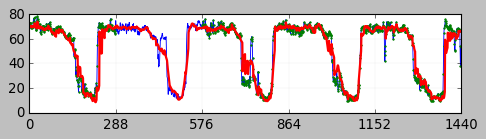

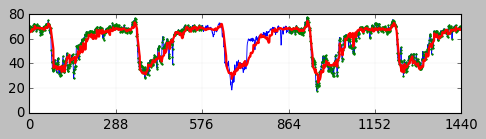

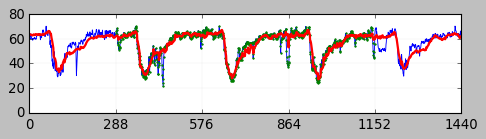

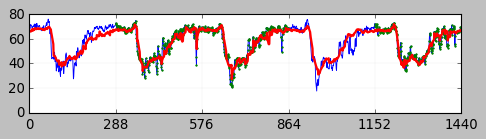

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [1, 2, 3, 4]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.05, 0.12, 0.90, 0.82])
    vec = sparse_mat[i, -pred_time_steps:]
    pos = np.where(vec > 0)
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(pos[0], vec[pos], '.', color='g', markersize = 3)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 288 * 5 + 1, 288))
    plt.yticks(np.arange(0, 80 + 1, 20))
    ax.set_xlim([0, pred_time_steps]) 
    ax.set_ylim([0, 80])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()
#     fig.savefig("../images/P{}_forecasting_time_series_40NM.pdf".format(i + 1))

### Parameter validation

Here, we should do a validation process for choosing best `rho`, `lambda0`, and `theta` on PeMS data.

In [ ]:
import time
start = time.time()
time_horizon = 9
pred_time_steps = 160 * time_horizon
validation_time_steps = 20 * time_horizon
time_intervals = 288
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
alpha = np.ones(3) / 3
rhos = [1e-4, 5e-4, 1e-3]
lambdas = [0, 0.1, 0.5, 1, 5, 10]
epsilon = 1e-4
maxiter = 100
thetas = [0, 5, 10, 15]
mape, rmse = validation(dense_mat[:, : - pred_time_steps], sparse_mat[:, : - pred_time_steps], 
                        validation_time_steps, time_horizon, back_time_steps, time_intervals,
                        time_lags, alpha, rhos, lambdas, thetas, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

### Results

Prediction task: $\tau=9$ and $S=160$.

<div class="alert alert-block alert-success">
<b>LATC-predictor</b>: Prediction performance on <b>PeMS data</b>.
</div>

<table>
<tr>
    <th></th> <th>Original data</th> <th>20%, RM</th> <th>40%, RM</th> <th>20%, NM</th> <th>40%, NM</th>
</tr>
<tr>
    <td>MAPE</td> <td>6.39</td> <td>6.53</td> <td>6.82</td> <td>7.32</td> <td>7.88</td>
</tr>
<tr>
    <td>RMSE</td> <td>4.97</td> <td>5.07</td> <td>5.16</td> <td>5.35</td> <td>5.65</td>
</tr>
</table>

### Guangzhou data

We generate **random missing (RM)** values on Guangzhou traffic speed data set.

In [14]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

dense_mat = ten2mat(dense_tensor, 0)
sparse_mat = ten2mat(sparse_tensor, 0)

We use `predictor` to predict time series (time horizon: 12) with missing values and measure performance metrics on the ground truth.

In [15]:
import time
start = time.time()
time_horizon = 12
pred_time_steps = 84 * time_horizon
time_intervals = 144
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 0.5 * rho
epsilon = 1e-4
maxiter = 100
theta = 10
mat_hat, mape, rmse = predictor(dense_mat, sparse_mat, 
                                pred_time_steps, time_horizon, back_time_steps, time_intervals,
                                time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
Iter: 100
Tolerance: 0.000646011
MAPE: 0.0781984
RMSE: 3.28199

Total iteration: 100
Tolerance: 0.000646011
Imputation MAPE: 0.0781984
Imputation RMSE: 3.28199

The current prediction step: 2
Iter: 100
Tolerance: 0.000499725
MAPE: 0.0781776
RMSE: 3.28172

Total iteration: 100
Tolerance: 0.000499725
Imputation MAPE: 0.0781776
Imputation RMSE: 3.28172

The current prediction step: 3
Iter: 100
Tolerance: 0.000533105
MAPE: 0.0781481
RMSE: 3.28066

Total iteration: 100
Tolerance: 0.000533105
Imputation MAPE: 0.0781481
Imputation RMSE: 3.28066

The current prediction step: 4
Iter: 100
Tolerance: 0.000315901
MAPE: 0.0783897
RMSE: 3.29007

Total iteration: 100
Tolerance: 0.000315901
Imputation MAPE: 0.0783897
Imputation RMSE: 3.29007

The current prediction step: 5
Iter: 100
Tolerance: 0.000644612
MAPE: 0.07833
RMSE: 3.288

Total iteration: 100
Tolerance: 0.000644612
Imputation MAPE: 0.07833
Imputation RMSE: 3.288

The current prediction step: 6
Iter: 100
Toleran

Iter: 100
Tolerance: 0.000308498
MAPE: 0.0790404
RMSE: 3.30109

Total iteration: 100
Tolerance: 0.000308498
Imputation MAPE: 0.0790404
Imputation RMSE: 3.30109

The current prediction step: 47
Iter: 100
Tolerance: 0.000558111
MAPE: 0.0791674
RMSE: 3.30071

Total iteration: 100
Tolerance: 0.000558111
Imputation MAPE: 0.0791674
Imputation RMSE: 3.30071

The current prediction step: 48
Iter: 100
Tolerance: 0.000671948
MAPE: 0.0791157
RMSE: 3.29745

Total iteration: 100
Tolerance: 0.000671948
Imputation MAPE: 0.0791157
Imputation RMSE: 3.29745

The current prediction step: 49
Iter: 100
Tolerance: 0.000592861
MAPE: 0.0791027
RMSE: 3.29802

Total iteration: 100
Tolerance: 0.000592861
Imputation MAPE: 0.0791027
Imputation RMSE: 3.29802

The current prediction step: 50
Iter: 100
Tolerance: 0.000158185
MAPE: 0.079133
RMSE: 3.29834

Total iteration: 100
Tolerance: 0.000158185
Imputation MAPE: 0.079133
Imputation RMSE: 3.29834

The current prediction step: 51
Iter: 100
Tolerance: 0.000341878
MAPE

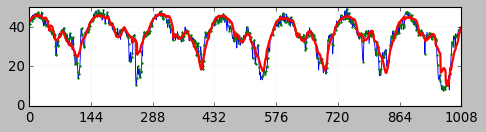

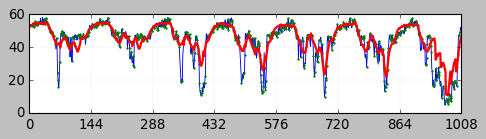

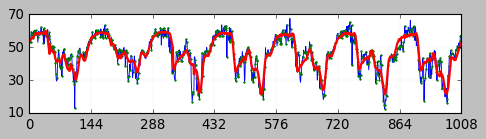

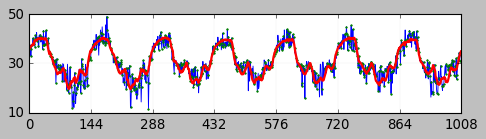

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

dense_mat = ten2mat(dense_tensor, 0)
sparse_mat = ten2mat(sparse_tensor, 0)

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [0, 1, 2, 3]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.05, 0.12, 0.90, 0.82])
    vec = sparse_mat[i, -pred_time_steps:]
    pos = np.where(vec > 0)
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(pos[0], vec[pos], '.', color='g', markersize = 3)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 144 * 7 + 1, 144))
    if i == 0:
        plt.yticks(np.arange(0, 50 + 1, 20))
    elif i == 1:
        plt.yticks(np.arange(0, 70 + 1, 20))
    elif i == 2:
        plt.yticks(np.arange(10, 70 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(10, 50 + 1, 20))
    ax.set_xlim([0, pred_time_steps])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()
#     fig.savefig("../images/G{}_forecasting_time_series_40RM.pdf".format(i + 1))

We generate **nonrandom missing (NM)** values on Guangzhou traffic speed data set.

In [17]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

missing_rate = 0.4

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = np.transpose(dense_tensor, [0, 2, 1])
sparse_tensor = np.transpose(sparse_tensor, [0, 2, 1])

dense_mat = ten2mat(dense_tensor, 0)
sparse_mat = ten2mat(sparse_tensor, 0)

In [18]:
import time
start = time.time()
time_horizon = 12
pred_time_steps = 84 * time_horizon
time_intervals = 144
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 0 * rho
epsilon = 1e-4
maxiter = 100
theta = 15
mat_hat, mape, rmse = predictor(dense_mat, sparse_mat, 
                                pred_time_steps, time_horizon, back_time_steps, time_intervals,
                                time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
Iter: 100
Tolerance: 0.000996972
MAPE: 0.103908
RMSE: 4.42953

Total iteration: 100
Tolerance: 0.000996972
Imputation MAPE: 0.103908
Imputation RMSE: 4.42953

The current prediction step: 2
Iter: 100
Tolerance: 0.000795989
MAPE: 0.103902
RMSE: 4.43169

Total iteration: 100
Tolerance: 0.000795989
Imputation MAPE: 0.103902
Imputation RMSE: 4.43169

The current prediction step: 3
Iter: 100
Tolerance: 0.00102758
MAPE: 0.103758
RMSE: 4.42236

Total iteration: 100
Tolerance: 0.00102758
Imputation MAPE: 0.103758
Imputation RMSE: 4.42236

The current prediction step: 4
Iter: 100
Tolerance: 0.000935715
MAPE: 0.103861
RMSE: 4.42666

Total iteration: 100
Tolerance: 0.000935715
Imputation MAPE: 0.103861
Imputation RMSE: 4.42666

The current prediction step: 5
Iter: 100
Tolerance: 0.000808206
MAPE: 0.103781
RMSE: 4.42109

Total iteration: 100
Tolerance: 0.000808206
Imputation MAPE: 0.103781
Imputation RMSE: 4.42109

The current prediction step: 6
Iter: 100
Tolerance: 

Iter: 100
Tolerance: 0.000979664
MAPE: 0.103863
RMSE: 4.40408

Total iteration: 100
Tolerance: 0.000979664
Imputation MAPE: 0.103863
Imputation RMSE: 4.40408

The current prediction step: 46
Iter: 100
Tolerance: 0.000810882
MAPE: 0.103982
RMSE: 4.40952

Total iteration: 100
Tolerance: 0.000810882
Imputation MAPE: 0.103982
Imputation RMSE: 4.40952

The current prediction step: 47
Iter: 100
Tolerance: 0.000989193
MAPE: 0.104385
RMSE: 4.42077

Total iteration: 100
Tolerance: 0.000989193
Imputation MAPE: 0.104385
Imputation RMSE: 4.42077

The current prediction step: 48
Iter: 100
Tolerance: 0.000755456
MAPE: 0.104479
RMSE: 4.43169

Total iteration: 100
Tolerance: 0.000755456
Imputation MAPE: 0.104479
Imputation RMSE: 4.43169

The current prediction step: 49
Iter: 100
Tolerance: 0.000844279
MAPE: 0.104302
RMSE: 4.42109

Total iteration: 100
Tolerance: 0.000844279
Imputation MAPE: 0.104302
Imputation RMSE: 4.42109

The current prediction step: 50
Iter: 100
Tolerance: 0.000734811
MAPE: 0.1042

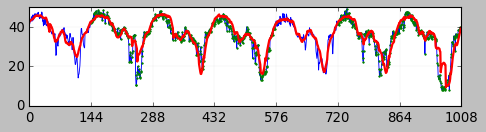

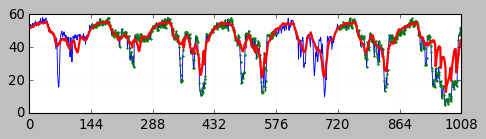

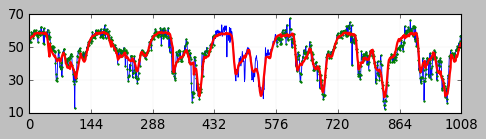

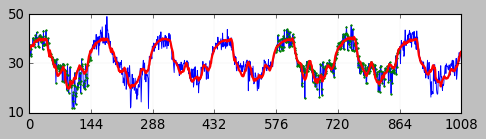

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

dense_mat = ten2mat(dense_tensor, 0)
sparse_mat = ten2mat(sparse_tensor, 0)

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [0, 1, 2, 3]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.05, 0.12, 0.90, 0.82])
    vec = sparse_mat[i, -pred_time_steps:]
    pos = np.where(vec > 0)
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(pos[0], vec[pos], '.', color='g', markersize = 3)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 144 * 7 + 1, 144))
    if i == 0:
        plt.yticks(np.arange(0, 50 + 1, 20))
    elif i == 1:
        plt.yticks(np.arange(0, 70 + 1, 20))
    elif i == 2:
        plt.yticks(np.arange(10, 70 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(10, 50 + 1, 20))
    ax.set_xlim([0, pred_time_steps]) 
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()
#     fig.savefig("../images/G{}_forecasting_time_series_40NM.pdf".format(i + 1))

### Parameter validation

Here, we should do a validation process for choosing best `rho`, `lambda0`, and `theta` on Guangzhou data.

In [ ]:
import time
start = time.time()
time_horizon = 12
pred_time_steps = 84 * time_horizon
validation_time_steps = 10 * time_horizon
time_intervals = 144
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rhos = [1e-4, 5e-4, 1e-3]
lambdas = [0, 0.1, 0.5, 1, 5, 10]
epsilon = 1e-4
maxiter = 100
thetas = [0, 5, 10, 15]
mape, rmse = validation(dense_mat[:, : - pred_time_steps], sparse_mat[:, : - pred_time_steps], 
                        validation_time_steps, time_horizon, back_time_steps, time_intervals,
                        time_lags, alpha, rhos, lambdas, thetas, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

### Results

Prediction task: $\tau=12$ and $S=84$.

<div class="alert alert-block alert-success">
<b>LATC-predictor</b>: Prediction performance on <b>Guangzhou data</b>.
</div>

<table>
<tr>
    <th></th> <th>Original data</th> <th>20%, RM</th> <th>40%, RM</th> <th>20%, NM</th> <th>40%, NM</th>
</tr>
<tr>
    <td>MAPE</td> <td>10.39</td> <td>10.42</td> <td>10.48</td> <td>10.48</td> <td>10.67</td>
</tr>
<tr>
    <td>RMSE</td> <td>4.29</td> <td>4.30</td> <td>4.33</td> <td>4.34</td> <td>4.42</td>
</tr>
</table>

### Electricity data

In [20]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_tensor = np.load('../datasets/Electricity-data-set/random_tensor.npy')

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

In [21]:
import time
start = time.time()
time_horizon = 6
pred_time_steps = 20 * time_horizon
time_intervals = 24
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-7
lambda0 = 0 * rho
epsilon = 1e-4
maxiter = 100
theta = 1
mat_hat, mape, rmse = predictor(dense_mat, sparse_mat, 
                                pred_time_steps, time_horizon, back_time_steps, time_intervals,
                                time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
Iter: 100
Tolerance: 0.000202064
MAPE: 0.106979
RMSE: 637.756

Total iteration: 100
Tolerance: 0.000202064
Imputation MAPE: 0.106979
Imputation RMSE: 637.756

The current prediction step: 2
Iter: 100
Tolerance: 0.000200815
MAPE: 0.107869
RMSE: 666.012

Total iteration: 100
Tolerance: 0.000200815
Imputation MAPE: 0.107869
Imputation RMSE: 666.012

The current prediction step: 3
Iter: 100
Tolerance: 0.000204175
MAPE: 0.10824
RMSE: 603.802

Total iteration: 100
Tolerance: 0.000204175
Imputation MAPE: 0.10824
Imputation RMSE: 603.802

The current prediction step: 4
Iter: 100
Tolerance: 0.000205728
MAPE: 0.108113
RMSE: 655.317

Total iteration: 100
Tolerance: 0.000205728
Imputation MAPE: 0.108113
Imputation RMSE: 655.317

The current prediction step: 5
Iter: 100
Tolerance: 0.000212989
MAPE: 0.108143
RMSE: 650.822

Total iteration: 100
Tolerance: 0.000212989
Imputation MAPE: 0.108143
Imputation RMSE: 650.822

The current prediction step: 6
Iter: 100
Tolerance: 

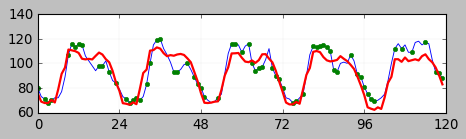

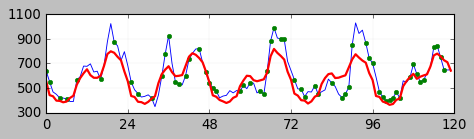

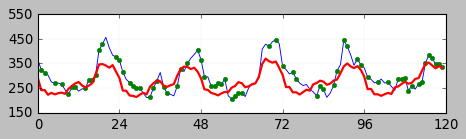

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [1, 3, 4]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.10, 0.12, 0.85, 0.82])
    vec = sparse_mat[i, -pred_time_steps:]
    pos = np.where(vec > 0)
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(pos[0], vec[pos], '.', color='g', markersize = 8)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 24 * 5 + 1, 24))
    if i == 1:
        plt.yticks(np.arange(60, 140 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(300, 1100 + 1, 200))
    elif i == 4:
        plt.yticks(np.arange(150, 600 + 1, 100))
    ax.set_xlim([0, pred_time_steps])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()
#     fig.savefig("../images/E{}_forecasting_time_series_40RM.pdf".format(i + 1))

In [23]:
dense_mat = np.load('../datasets/Electricity-data-set/electricity35.npy')
random_matrix = np.load('../datasets/Electricity-data-set/random_matrix.npy')

missing_rate = 0.4

### Nonrandom missing (NM) scenario:
binary_tensor = np.zeros((dense_mat.shape[0], 24, 35))
for i1 in range(dense_mat.shape[0]):
    for i2 in range(35):
        binary_tensor[i1,:,i2] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = ten2mat(binary_tensor, 0)
sparse_mat = np.multiply(dense_mat, binary_mat)

In [24]:
import time
start = time.time()
time_horizon = 6
pred_time_steps = 20 * time_horizon
time_intervals = 24
back_time_steps = 28 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rho = 1e-7
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
theta = 1
mat_hat, mape, rmse = predictor(dense_mat, sparse_mat, 
                                pred_time_steps, time_horizon, back_time_steps, time_intervals,
                                time_lags, alpha, rho, lambda0, theta, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

The current prediction step: 1
Iter: 100
Tolerance: 0.00019834
MAPE: 0.132552
RMSE: 814.701

Total iteration: 100
Tolerance: 0.00019834
Imputation MAPE: 0.132552
Imputation RMSE: 814.701

The current prediction step: 2
Iter: 100
Tolerance: 0.000202118
MAPE: 0.136423
RMSE: 970.789

Total iteration: 100
Tolerance: 0.000202118
Imputation MAPE: 0.136423
Imputation RMSE: 970.789

The current prediction step: 3
Iter: 100
Tolerance: 0.00020342
MAPE: 0.135241
RMSE: 917.84

Total iteration: 100
Tolerance: 0.00020342
Imputation MAPE: 0.135241
Imputation RMSE: 917.84

The current prediction step: 4
Iter: 100
Tolerance: 0.000200649
MAPE: 0.133813
RMSE: 877.616

Total iteration: 100
Tolerance: 0.000200649
Imputation MAPE: 0.133813
Imputation RMSE: 877.616

The current prediction step: 5
Iter: 100
Tolerance: 0.0002072
MAPE: 0.133586
RMSE: 800.607

Total iteration: 100
Tolerance: 0.0002072
Imputation MAPE: 0.133586
Imputation RMSE: 800.607

The current prediction step: 6
Iter: 100
Tolerance: 0.000206

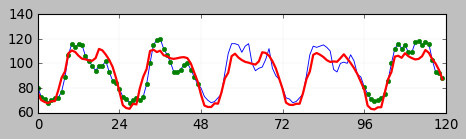

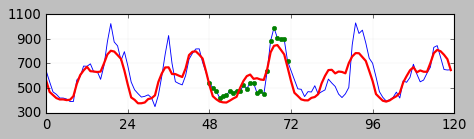

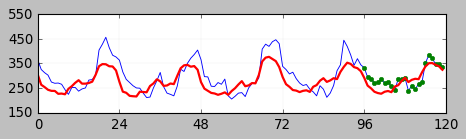

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [1, 3, 4]:
    fig = plt.figure(figsize=(6, 1.5))
    ax = fig.add_axes([0.10, 0.12, 0.85, 0.82])
    vec = sparse_mat[i, -pred_time_steps:]
    pos = np.where(vec > 0)
    plt.plot(dense_mat[i, -pred_time_steps:], color = 'b', linewidth = 0.8)
    plt.plot(pos[0], vec[pos], '.', color='g', markersize = 8)
    plt.plot(mat_hat[i, -pred_time_steps:], color = 'r', linewidth = 2)
    plt.xticks(np.arange(0, 24 * 5 + 1, 24))
    if i == 1:
        plt.yticks(np.arange(60, 140 + 1, 20))
    elif i == 3:
        plt.yticks(np.arange(300, 1100 + 1, 200))
    elif i == 4:
        plt.yticks(np.arange(150, 600 + 1, 100))
    ax.set_xlim([0, pred_time_steps])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()
#     fig.savefig("../images/E{}_forecasting_time_series_40NM.pdf".format(i + 1))

### Parameter validation

Here, we should do a validation process for choosing best `rho`, `lambda0`, and `theta` on Electricity data.

In [ ]:
import time
start = time.time()
time_horizon = 6
pred_time_steps = 10 * time_horizon
validation_time_steps = 10 * time_horizon
time_intervals = 24
back_time_steps = 27 * time_intervals
time_lags = np.array([1, 2, 3, 4, 5, 6, 22, 23, 24, 25, 26, 27])
alpha = np.ones(3) / 3
rhos = [1e-7, 1e-6, 1e-5]
lambdas = [0, 0.1 * rho, 0.5 * rho, 1 * rho, 5 * rho, 10 * rho]
epsilon = 1e-4
maxiter = 100
thetas = [0, 1, 3, 5, 10, 15]
mape, rmse = validation(dense_mat[:, : - pred_time_steps], sparse_mat[:, : - pred_time_steps], 
                        validation_time_steps, time_horizon, back_time_steps, time_intervals,
                        time_lags, alpha, rhos, lambdas, thetas, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

### Results

Prediction task: $\tau=6$ and $S=20$.

<div class="alert alert-block alert-success">
<b>LATC-predictor</b>: Prediction performance on <b>Electricity data</b>.
</div>

<table>
<tr>
    <th></th> <th>Original data</th> <th>20%, RM</th> <th>40%, RM</th> <th>20%, NM</th> <th>40%, NM</th>
</tr>
<tr>
    <td>MAPE</td> <td>24.94</td> <td>26.31</td> <td>26.63</td> <td>26.78</td> <td>27.00</td>
</tr>
<tr>
    <td>RMSE</td> <td>779</td> <td>863</td> <td>890</td> <td>861</td> <td>888</td>
</tr>
</table>

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>